In [1]:
!pip install git+https://github.com/samoturk/mol2vec;

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-l2g1rh7w
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-l2g1rh7w
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 8.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.6 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14015 sha256=f4bea827f781c223a13164a9ac4040e5eeb93e8d7328af89d35e638fde21ff71
  Stored in directory: /tmp/pip-ephem-wheel-cache-f51jlr16/wheels/80/d5/e1/90dc211e4a17780f99eaec43328470a70284cd731ef2a77034
Successfully built mol2vec


In [14]:
!pip install gensim==3.7.1

  Using cached gensim-3.7.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)


In [1]:
import gensim
print(gensim.__version__) # 3.7.1

3.7.1


In [2]:
import pandas as pd
import numpy as np
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit import Chem
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV, LassoCV, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from catboost import CatBoostRegressor

In [81]:
def concatenate_sentences(vec_list):
    vec_arrays = [x.sentence for x in vec_list]
    concatenated_vec = np.concatenate(vec_arrays)
    return concatenated_vec

directory = './materials/'
mdf = pd.read_csv(directory+"smiles_train_set.csv")
mdf['mol'] = mdf['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
rows_to_drop = mdf[mdf['mol'].isnull()].index
mdf = mdf.drop(mdf[mdf['blend_id'].isin(mdf.loc[rows_to_drop, 'blend_id'])].index)
model = word2vec.Word2Vec.load(directory+'model_300dim.pkl')
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
grouped_mdf = mdf.groupby('blend_id')['sentence'].apply(concatenate_sentences).reset_index()
grouped_mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(grouped_mdf['sentence'], model, unseen='UNK')]
blend_id_without_nulls = mdf.groupby('blend_id')['oil_property_param_value'].mean().dropna().index.tolist()
rows_to_drop = mdf[mdf['mol'].isnull()].index
grouped_mdf = grouped_mdf[grouped_mdf['blend_id'].isin(blend_id_without_nulls)]
X = np.array([x.vec for x in grouped_mdf['mol2vec']])

target = mdf.groupby('blend_id')['oil_property_param_value'].mean().dropna()
y = target.values

RDKit ERROR: [04:35:22] Explicit valence for atom # 5 C, 5, is greater than permitted
[04:35:22] Explicit valence for atom # 5 C, 5, is greater than permitted
RDKit ERROR: [04:35:22] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [04:35:22] SMILES Parse Error: syntax error while parsing: O=S(C1=CC=C([C18H21])C=C1)(O)=O
RDKit ERROR: [04:35:22] SMILES Parse Error: Failed parsing SMILES 'O=S(C1=CC=C([C18H21])C=C1)(O)=O' for input: 'O=S(C1=CC=C([C18H21])C=C1)(O)=O'
RDKit ERROR: [04:35:22] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [04:35:22] Explicit valence for atom # 6 C, 5, is greater than permitted
[04:35:22] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [04:35:22] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [04:35:22] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [04:35:22] Explicit valence for atom # 6 C, 5, is greater than permitted
[04

(317, 300)

In [82]:
print(y.shape)
print("\n", X.shape)

(317,)

/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e+08, tolerance: 2.032e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e+08, tolerance: 2.032e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

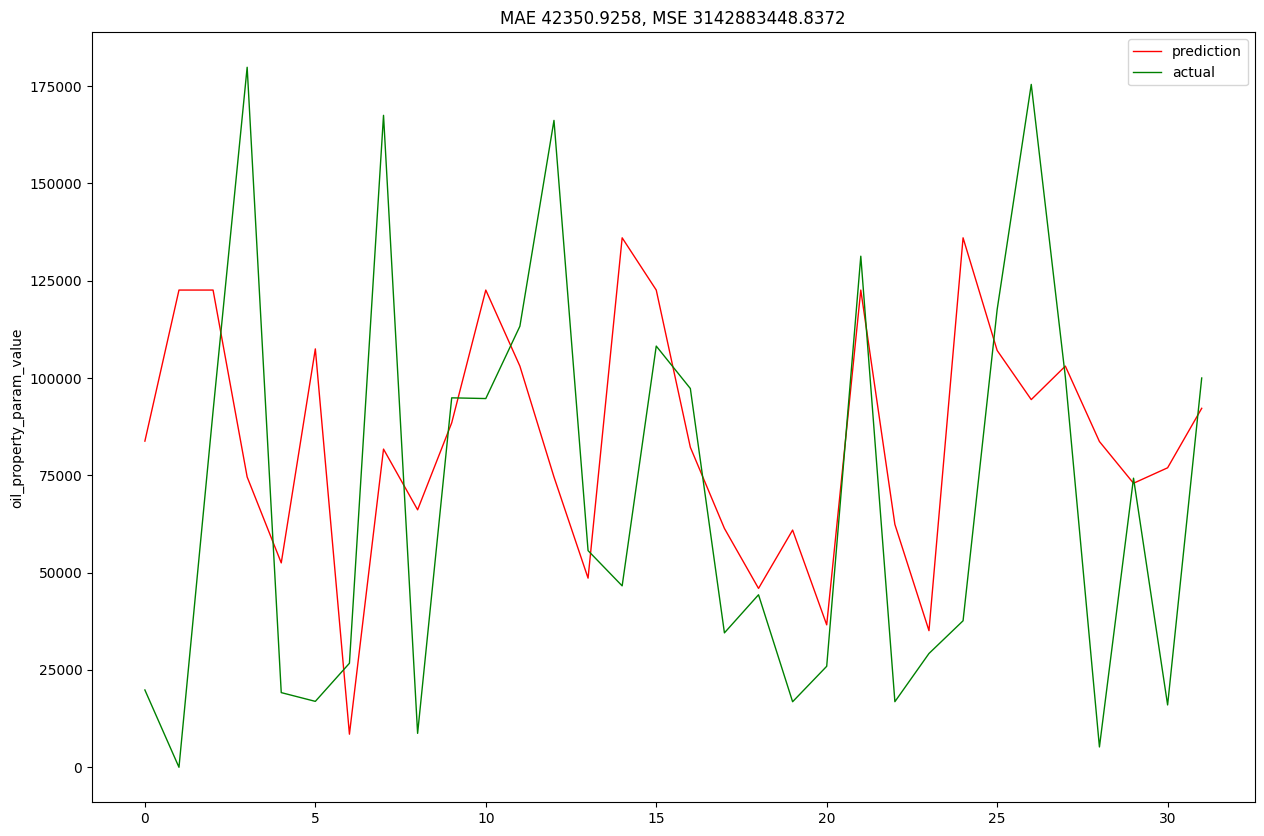

MAE score: 42350.9258
MSE score: 3142883448.8372


In [84]:
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('oil_property_param_value')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
evaluation(lasso, X_test, y_test)

/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.78729e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.69614e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.28193e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=8.23146e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, ove

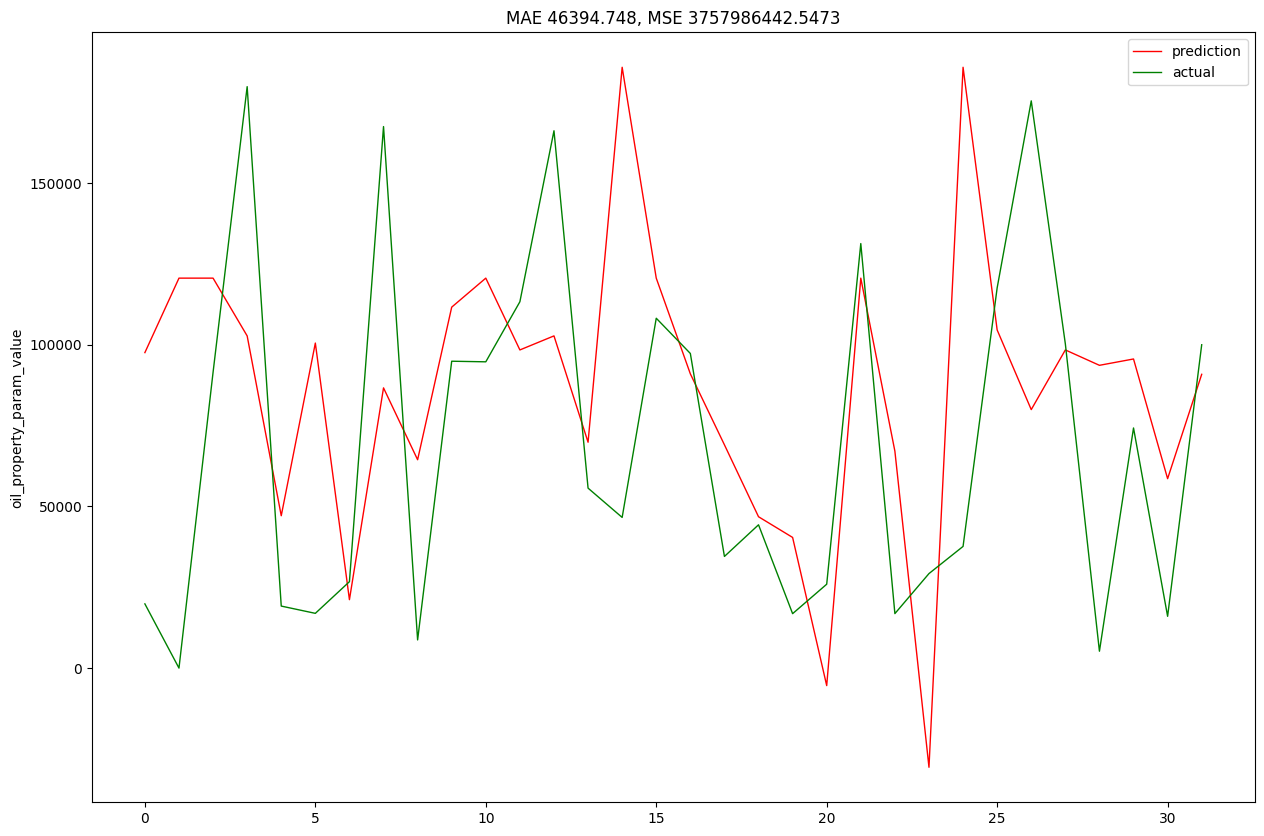

MAE score: 46394.748
MSE score: 3757986442.5473


In [87]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

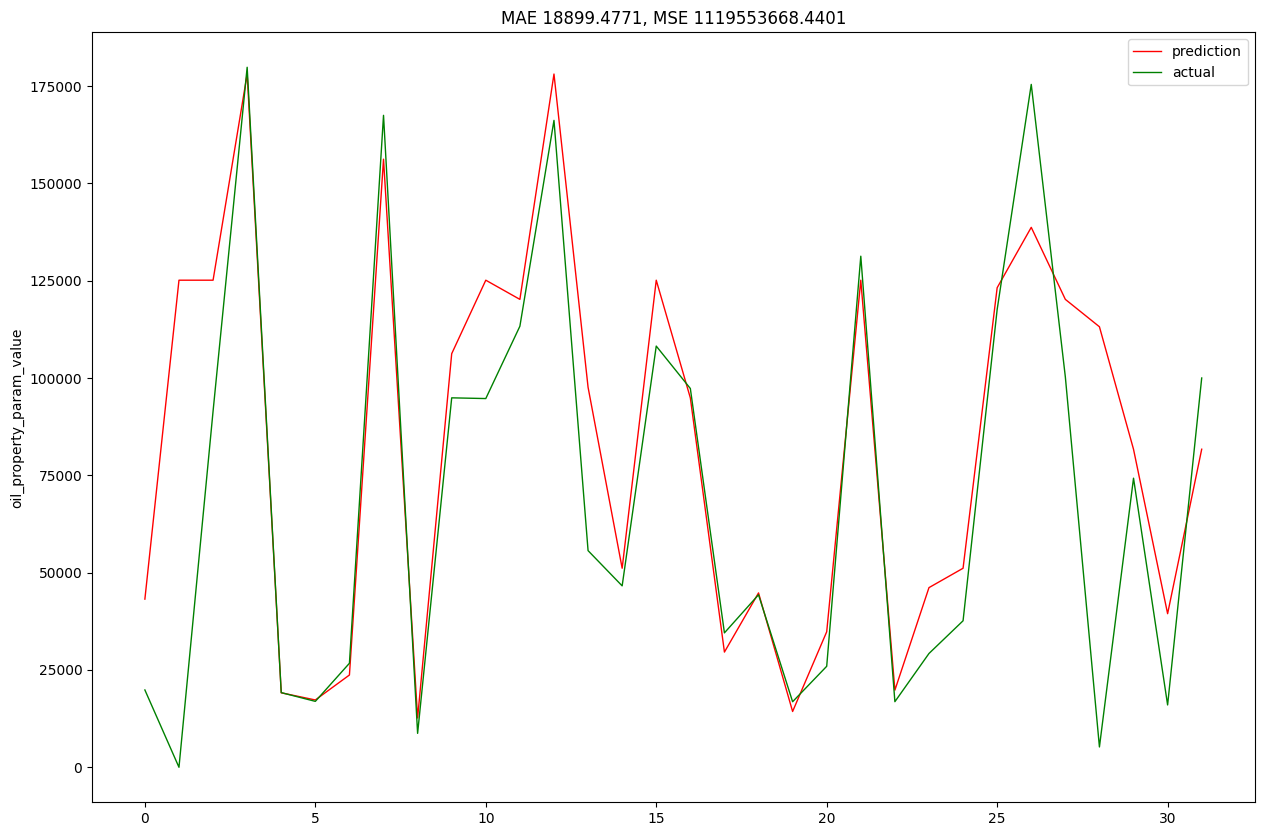

MAE score: 18899.4771
MSE score: 1119553668.4401


In [85]:
# RandomForest регрессия
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
evaluation(rf, X_test, y_test)

0:	learn: 85899.7548537	test: 53457.1790016	best: 53457.1790016 (0)	total: 97.7ms	remaining: 1m 37s
100:	learn: 41244.2225204	test: 33129.3536706	best: 33129.3536706 (100)	total: 2.76s	remaining: 24.5s
200:	learn: 40091.5348220	test: 33953.9269013	best: 33129.3536706 (100)	total: 5.18s	remaining: 20.6s
300:	learn: 40014.0444756	test: 34533.9579698	best: 33129.3536706 (100)	total: 9.55s	remaining: 22.2s
400:	learn: 40007.2379072	test: 34753.8041232	best: 33129.3536706 (100)	total: 14.2s	remaining: 21.3s
500:	learn: 40006.5395320	test: 34807.4928889	best: 33129.3536706 (100)	total: 19.1s	remaining: 19s
600:	learn: 40006.4096012	test: 34835.6460436	best: 33129.3536706 (100)	total: 22.9s	remaining: 15.2s
700:	learn: 40006.3761848	test: 34847.0769264	best: 33129.3536706 (100)	total: 25.9s	remaining: 11s
800:	learn: 40006.3679612	test: 34853.2533246	best: 33129.3536706 (100)	total: 28.7s	remaining: 7.13s
900:	learn: 40006.3655573	test: 34855.9584777	best: 33129.3536706 (100)	total: 31.9s	rem

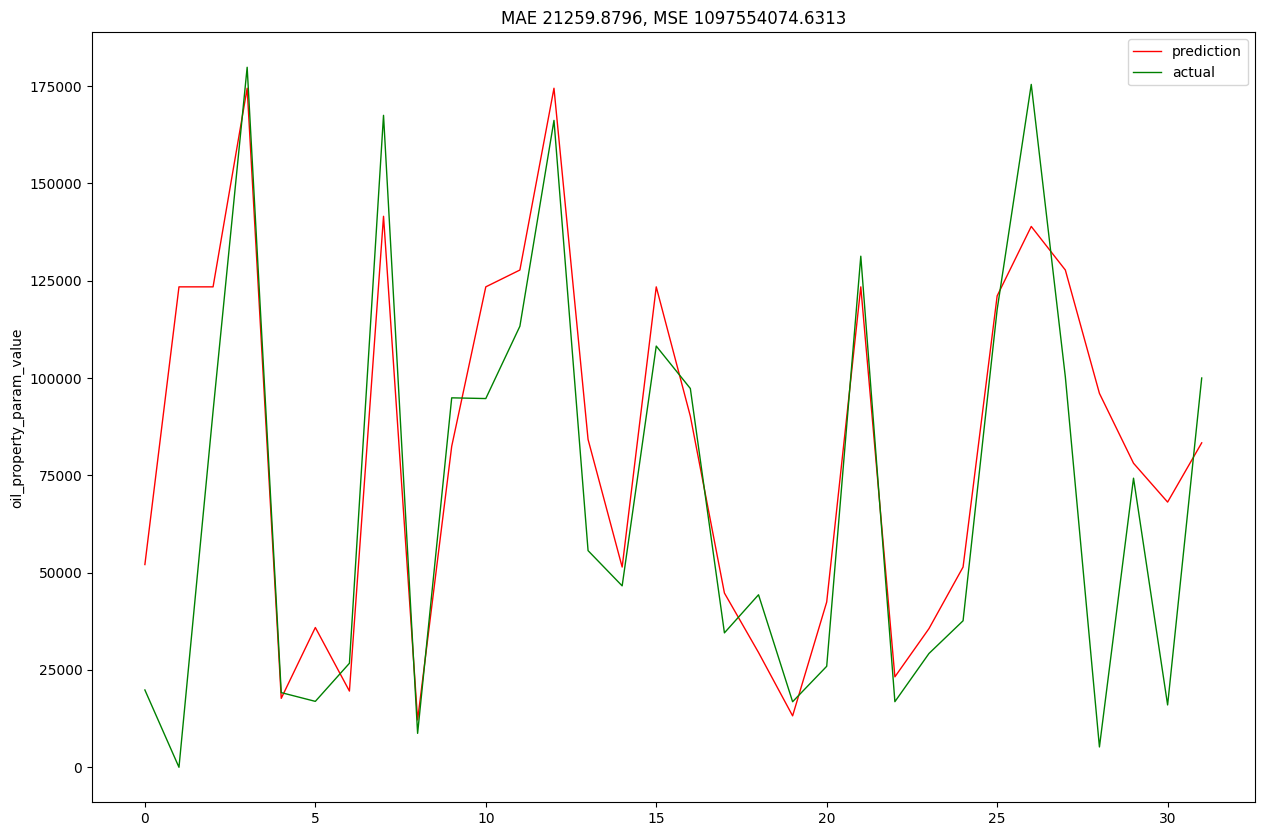

MAE score: 21259.8796
MSE score: 1097554074.6313


In [88]:
catboost = CatBoostRegressor(iterations=1000, learning_rate=0.1, loss_function='RMSE', random_seed=1)
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)
evaluation(catboost, X_test, y_test)
